In [1]:
import numpy as np
import matplotlib.pyplot as plt
from h5py import File

import csiborgtools


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [69]:
def read_key(key, stationary_observer=False):
    nsims = range(51)
    bfs = [None] * len(nsims)
    for nsim in nsims:
        if stationary_observer:
            fname = f"/mnt/extraspace/rstiskalek/quijote/BulkFlow_fiducial/sBF_nsim_{nsim}.hdf5"
        else:
            fname = f"/mnt/extraspace/rstiskalek/quijote/BulkFlow_fiducial/BF_nsim_{nsim}.hdf5"

        with File(fname, 'r') as f:
            if nsim == 0:
                print("Keys are: ", list(f.keys()))
                distances = f['distances'][...]
            bfs[nsim] = f[key][...]

    bfs = np.asarray(bfs)

    ndist = len(distances)
    bx = np.asarray([bfs[..., i, 0].reshape(-1, ) for i in range(ndist)]).T
    by = np.asarray([bfs[..., i, 1].reshape(-1, ) for i in range(ndist)]).T
    bz = np.asarray([bfs[..., i, 2].reshape(-1, ) for i in range(ndist)]).T

    return distances, np.stack([bx, by, bz], axis=-1)


### Bulk flow in the cosmic (simulation) rest frame

Keys are:  ['bf_volume_halo', 'bf_volume_halo_uniform', 'bf_volume_part', 'bf_vrad_weighted_halo', 'bf_vrad_weighted_halo_uniform', 'bf_vrad_weighted_part', 'distances', 'obs_0', 'obs_1', 'obs_10', 'obs_11', 'obs_12', 'obs_13', 'obs_14', 'obs_15', 'obs_16', 'obs_17', 'obs_18', 'obs_19', 'obs_2', 'obs_20', 'obs_21', 'obs_22', 'obs_23', 'obs_24', 'obs_25', 'obs_26', 'obs_3', 'obs_4', 'obs_5', 'obs_6', 'obs_7', 'obs_8', 'obs_9']
Keys are:  ['bf_volume_halo', 'bf_volume_halo_uniform', 'bf_volume_part', 'bf_vrad_weighted_halo', 'bf_vrad_weighted_halo_uniform', 'bf_vrad_weighted_part', 'distances', 'obs_0', 'obs_1', 'obs_10', 'obs_11', 'obs_12', 'obs_13', 'obs_14', 'obs_15', 'obs_16', 'obs_17', 'obs_18', 'obs_19', 'obs_2', 'obs_20', 'obs_21', 'obs_22', 'obs_23', 'obs_24', 'obs_25', 'obs_26', 'obs_3', 'obs_4', 'obs_5', 'obs_6', 'obs_7', 'obs_8', 'obs_9']


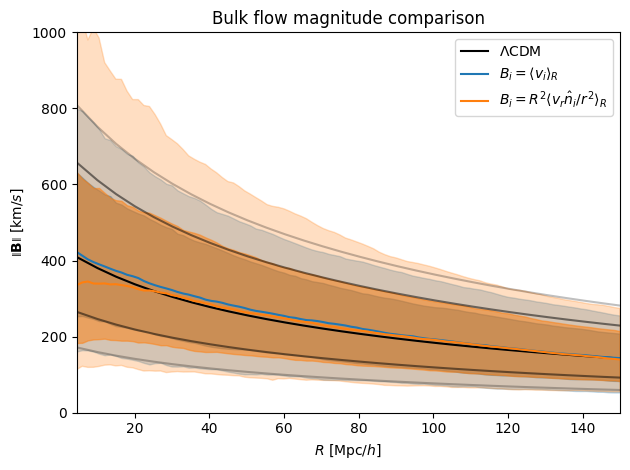

In [73]:
distances, bf_volume_part = read_key("bf_volume_part")
distances, bf_vrad_weighted_part = read_key("bf_vrad_weighted_part")

plt.figure()
plt.title("Bulk flow magnitude comparison")
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# LCDM expectation
Rs,mean,std,mode,p05,p16,p84,p95 = np.load("/mnt/users/rstiskalek/csiborgtools/data/BulkFlowPlot.npy")
m = Rs < 200
plt.plot(Rs[m], p05[m], color="black", alpha=0.25)
plt.plot(Rs[m], p95[m], color="black", alpha=0.25)
plt.plot(Rs[m], p16[m], color="black", alpha=0.5)
plt.plot(Rs[m], p84[m], color="black", alpha=0.5)
plt.plot(Rs[m], mode[m], color="black", label=r"$\Lambda\mathrm{CDM}$")

# Volume averaging
y = np.linalg.norm(bf_volume_part, axis=-1)
ylowlow, ylow, ymed, yhigh, yhighhigh = np.percentile(y, [5, 16, 50, 84, 95], axis=0)
plt.fill_between(distances, ylowlow, yhighhigh, alpha=0.25, color=cols[0])
plt.fill_between(distances, ylow, yhigh, alpha=0.5, color=cols[0])
plt.plot(distances, ymed, label=r"$B_i = \langle v_i \rangle_R$", color=cols[0])

# 1 / r^2
y = np.linalg.norm(bf_vrad_weighted_part, axis=-1)
ylowlow, ylow, ymed, yhigh, yhighhigh = np.percentile(y, [5, 16, 50, 84, 95], axis=0)
plt.fill_between(distances, ylowlow, yhighhigh, alpha=0.25, color=cols[1])
plt.fill_between(distances, ylow, yhigh, alpha=0.5, color=cols[1])
plt.plot(distances, ymed, label=r"$B_i = R^2 \langle v_r \hat{n}_i / r^2 \rangle_R$", color=cols[1])

plt.legend()
plt.xlim(distances[2], distances.max())
plt.ylim(0, 1000)

plt.xlabel(r"$R ~ [\mathrm{Mpc} / h]$")
plt.ylabel(r"$\left\| \mathbf{B} \right\| ~ [\mathrm{km} / s]$")
plt.tight_layout()
plt.savefig("../../plots/bf_comparison.png", dpi=450)
plt.show()

#### Component differences

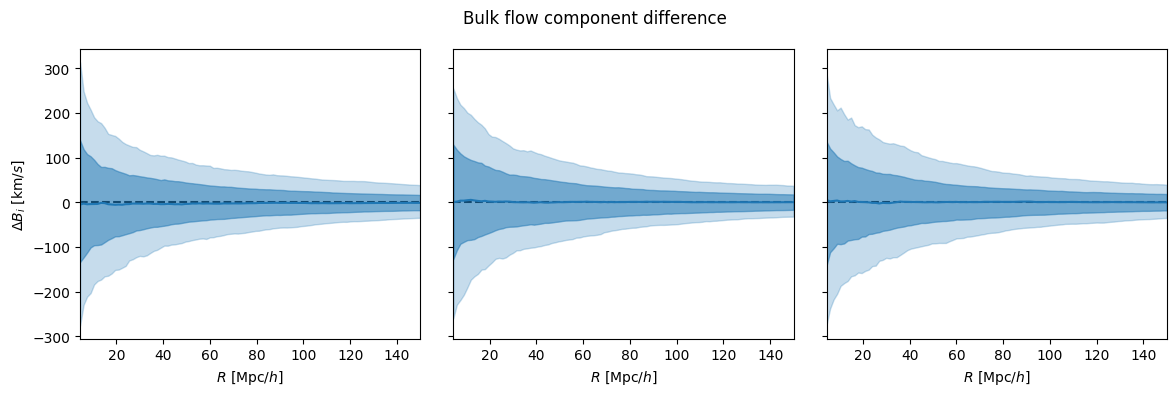

In [67]:
dx = bf_volume_part - bf_vrad_weighted_part

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.suptitle("Bulk flow component difference")
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i in range(3):
    y = dx[..., i]
    ylowlow, ylow, ymed, yhigh, yhighhigh = np.percentile(y, [5, 16, 50, 84, 95], axis=0)
    axs[i].fill_between(distances, ylowlow, yhighhigh, alpha=0.25, color=cols[0])
    axs[i].fill_between(distances, ylow, yhigh, alpha=0.5, color=cols[0])
    axs[i].plot(distances, ymed, color=cols[0])

    axs[i].set_xlabel(r"$R ~ [\mathrm{Mpc} / h]$")
    axs[i].set_xlim(distances[2], distances.max())
    axs[i].axhline(0, color="black", linestyle="--", zorder=0)

axs[0].set_ylabel(r"$\Delta B_i ~ [\mathrm{km} / s]$")
fig.tight_layout()
fig.savefig("../../plots/bf_difference.png", dpi=450)
fig.show()


###  Bulk flow in the observer rest frame

Keys are:  ['bf_volume_halo', 'bf_volume_halo_uniform', 'bf_volume_part', 'bf_vrad_weighted_halo', 'bf_vrad_weighted_halo_uniform', 'bf_vrad_weighted_part', 'distances', 'obs_0', 'obs_1', 'obs_10', 'obs_11', 'obs_12', 'obs_13', 'obs_14', 'obs_15', 'obs_16', 'obs_17', 'obs_18', 'obs_19', 'obs_2', 'obs_20', 'obs_21', 'obs_22', 'obs_23', 'obs_24', 'obs_25', 'obs_26', 'obs_3', 'obs_4', 'obs_5', 'obs_6', 'obs_7', 'obs_8', 'obs_9']
Keys are:  ['bf_volume_halo', 'bf_volume_halo_uniform', 'bf_volume_part', 'bf_vrad_weighted_halo', 'bf_vrad_weighted_halo_uniform', 'bf_vrad_weighted_part', 'distances', 'obs_0', 'obs_1', 'obs_10', 'obs_11', 'obs_12', 'obs_13', 'obs_14', 'obs_15', 'obs_16', 'obs_17', 'obs_18', 'obs_19', 'obs_2', 'obs_20', 'obs_21', 'obs_22', 'obs_23', 'obs_24', 'obs_25', 'obs_26', 'obs_3', 'obs_4', 'obs_5', 'obs_6', 'obs_7', 'obs_8', 'obs_9']


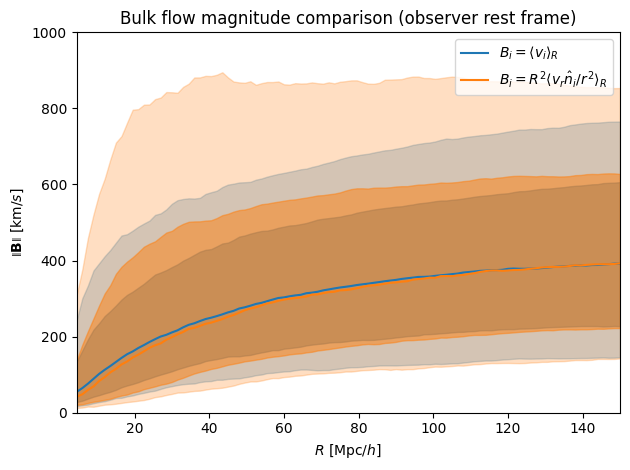

In [75]:
distances, bf_volume_part = read_key("bf_volume_part", True)
distances, bf_vrad_weighted_part = read_key("bf_vrad_weighted_part", True)

plt.figure()
plt.title("Bulk flow magnitude comparison (observer rest frame)")
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Volume averaging
y = np.linalg.norm(bf_volume_part, axis=-1)
ylowlow, ylow, ymed, yhigh, yhighhigh = np.percentile(y, [5, 16, 50, 84, 95], axis=0)
plt.fill_between(distances, ylowlow, yhighhigh, alpha=0.25, color=cols[0])
plt.fill_between(distances, ylow, yhigh, alpha=0.5, color=cols[0])
plt.plot(distances, ymed, label=r"$B_i = \langle v_i \rangle_R$", color=cols[0])

# 1 / r^2
y = np.linalg.norm(bf_vrad_weighted_part, axis=-1)
ylowlow, ylow, ymed, yhigh, yhighhigh = np.percentile(y, [5, 16, 50, 84, 95], axis=0)
plt.fill_between(distances, ylowlow, yhighhigh, alpha=0.25, color=cols[1])
plt.fill_between(distances, ylow, yhigh, alpha=0.5, color=cols[1])
plt.plot(distances, ymed, label=r"$B_i = R^2 \langle v_r \hat{n}_i / r^2 \rangle_R$", color=cols[1])

plt.legend()
plt.xlim(distances[2], distances.max())
plt.ylim(0, 1000)

plt.xlabel(r"$R ~ [\mathrm{Mpc} / h]$")
plt.ylabel(r"$\left\| \mathbf{B} \right\| ~ [\mathrm{km} / s]$")
plt.tight_layout()
plt.savefig("../../plots/bf_comparison_observer.png", dpi=450)
plt.show()